# Fibonacci recurrence

The [Fibonacci numbers](https://en.wikipedia.org/wiki/Fibonacci_number) are:

$$
1,1,2,3,5,8,13,21,34,\ldots
$$

Each number $f_n$ in the sequence is the sum of the previous two, defining the [recurrence relation](https://en.wikipedia.org/wiki/Recurrence_relation):

$$
f_n = f_{n-1} + f_{n-2}
$$

Perhaps the most obvious way to implement this in a programming language is via [recursion](https://en.wikipedia.org/wiki/Recursion_(computer_science)):

In [1]:
function slowfib(n)
    if n < 2
        return BigInt(1) # use bigint type to support huge integers
    else
        return slowfib(n-1) + slowfib(n-2)
    end
end

slowfib (generic function with 1 method)

Note that there is a slight catch: we have to make sure to do our computations with the `BigInt` integer type, which implements [arbitrary precision arithmetic](https://en.wikipedia.org/wiki/Arbitrary-precision_arithmetic).  The Fibonacci numbers quickly get so big that they [overflow](https://en.wikipedia.org/wiki/Integer_overflow) the maximum representable integer using the default (fast, fixed numbrer of binary digits) hardware integer type.

In [2]:
[slowfib(n) for n = 1:10]

10-element Array{BigInt,1}:
  1
  2
  3
  5
  8
 13
 21
 34
 55
 89

Not that it matters for toy calculations like this, but there are much faster ways to compute Fibonacci numbers than the [recursive](https://en.wikipedia.org/wiki/Recursion) function defined above.  The [GMP library](https://en.wikipedia.org/wiki/GNU_Multiple_Precision_Arithmetic_Library) used internally by Julia for `BigInt` arithmetic actually provides an [optimized Fibonacci-calculating function `mpz_fib_ui`](https://gmplib.org/manual/Number-Theoretic-Functions.html) that we can call if we want to using the low-level [`ccall` technique](https://docs.julialang.org/en/latest/manual/calling-c-and-fortran-code.html):

In [3]:
function fastfib(n)
    z = BigInt()
    ccall((:__gmpz_fib_ui, :libgmp), Void, (Ptr{BigInt}, Culong), &z, n)
    return z
end

fastfib (generic function with 1 method)

In [4]:
[fastfib(i) for i = 1:100]

100-element Array{BigInt,1}:
                     1
                     1
                     2
                     3
                     5
                     8
                    13
                    21
                    34
                    55
                    89
                   144
                   233
                     ⋮
   1779979416004714189
   2880067194370816120
   4660046610375530309
   7540113804746346429
  12200160415121876738
  19740274219868223167
  31940434634990099905
  51680708854858323072
  83621143489848422977
 135301852344706746049
 218922995834555169026
 354224848179261915075

It's about 1000x faster even for the 20th Fibonacci number.  It turns out that the recursive algorithm is pretty terrible — the [time increases exponentially with `n`](https://www.youtube.com/watch?v=pqivnzmSbq4).

In [5]:
@time fastfib(20)
@time slowfib(20)

  0.002777 seconds (164 allocations: 9.711 KB)
  0.010294 seconds (54.73 k allocations: 1.253 MB, 70.13% gc time)


10946

# Fibonacci as matrices

We can represent the Fibonacci recurrence as repeated multiplication by a $2 \times 2$ matrix, since:

$$
\begin{pmatrix} f_{n+1} \\ f_n \end{pmatrix} = 
\underbrace{\begin{pmatrix} 1 & 1 \\ 1 & 0 \end{pmatrix}}_F
\begin{pmatrix} f_{n} \\ f_{n-1} \end{pmatrix}
$$

In [6]:
F = [1 1
     1 0]

2×2 Array{Int64,2}:
 1  1
 1  0

So, plugging in $f_1 = 1, f_2 = 1$, then

$$
\begin{pmatrix} f_{n+2} \\ f_{n+1} \end{pmatrix} = 
F^n
\begin{pmatrix} 1 \\ 1 \end{pmatrix}
$$

and the key to understanding $F^n$ is the eigenvalues of $F$:

In [7]:
eigvals(F)

2-element Array{Float64,1}:
 -0.618034
  1.61803 

Analytically, we can easily solve this $2 \times 2$ eigenproblem to show that the eigenvalues are $(1 \pm \sqrt{5})/2$ (just the roots of the quadratic characteristic polynomial $\det (F-\lambda I) = \lambda^2 - \lambda - 1$):

In [8]:
(1 + √5)/2

1.618033988749895

In [9]:
(1 - √5)/2

-0.6180339887498949

For example, to compute $f_{100}$, we can multiply $F^{98}$ by $(1,1)$ (again converting to `BigInt` using `big` first to avoid overflow):

In [10]:
big(F)^98 * [1, 1]

2-element Array{BigInt,1}:
 354224848179261915075
 218922995834555169026

This matches our `fastfib` function from above:

In [11]:
fastfib(100)

354224848179261915075

An important thing about $F^n$ is that, for large $n$, the behavior is dominated by the biggest $|\lambda|$.   That is, for large $n$, we must have $(f_{n}, f_{n-1})$ approximately parallel to the corresponding eigenvector, and hence:

$$
\begin{pmatrix} f_{n+1} \\ f_{n} \end{pmatrix} =
F \begin{pmatrix} f_{n} \\ f_{n-1} \end{pmatrix}
\approx 
\lambda_1
\begin{pmatrix} f_{n} \\ f_{n-1} \end{pmatrix}
$$

where $\lambda_1 = (1 + \sqrt{5})/2$ is the so-called [golden ratio](https://en.wikipedia.org/wiki/Golden_ratio).

Let's compute the ratios of $f_{n+1}/f_{n}$ and show that they approach the golden ratio:

In [12]:
(1 + √big(5))/2 # golden ratio computed to many digits

1.61803398874989484820458683436563811772030917980576286213544862270526046281891

In [13]:
using Interact
@manipulate for n = 1:1000
    fastfib(n+1)/fastfib(n)
end

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(500, nactions=1),"n",500,"500",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(306=>"306",29=>"29",74=>"74",905=>"905",176=>"176",892=>"892",285=>"285",318=>"318",873=>"873",975=>"975"…)),Any[],Any[],true,"horizontal")

1.61803398874989484820458683436563811772030917980576286213544862270526046281891

We can also plot the ratio vs. $n$:

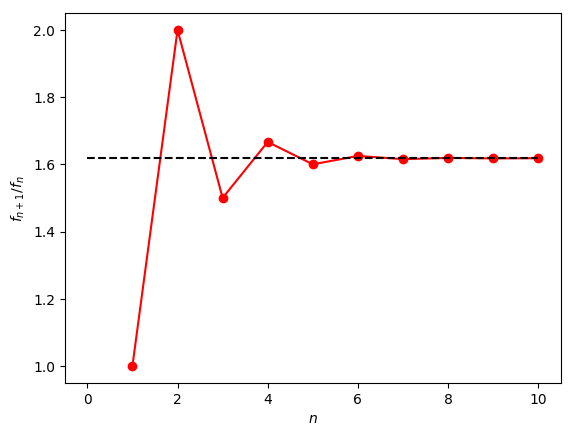

PyObject <matplotlib.text.Text object at 0x332cb6510>

In [14]:
using PyPlot
plot(1:10, [fastfib(n+1)/fastfib(n) for n=1:10], "ro-")
plot([0,10], (1+√5)/2 * [1,1], "k--")
xlabel(L"n")
ylabel(L"f_{n+1}/f_n")

Clearly, it converges rapidly as expected!

(In fact, it converges exponentially rapidly, with the error going exponentially to zero with $n$.  We will discuss this in more detail later when discussing the **power method**.)